# 20기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
![image.png](attachment:image.png)

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

In [2]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.5 MB/s eta 0:00:00


## 라이브러리 불러오기

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMAResults

<ipython-input-3-1e3c1defb90d>:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [9]:

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,582 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120831 files and dire

## 데이터 불러오기

In [4]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


In [6]:
samsung_df.isna().sum()

price    0
dtype: int64

### 식별
- 자료의 시계열도, ACF, PACF등 이용
- 차분의 필요 여부와 모형의 차수를 잠정적으로 결정

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


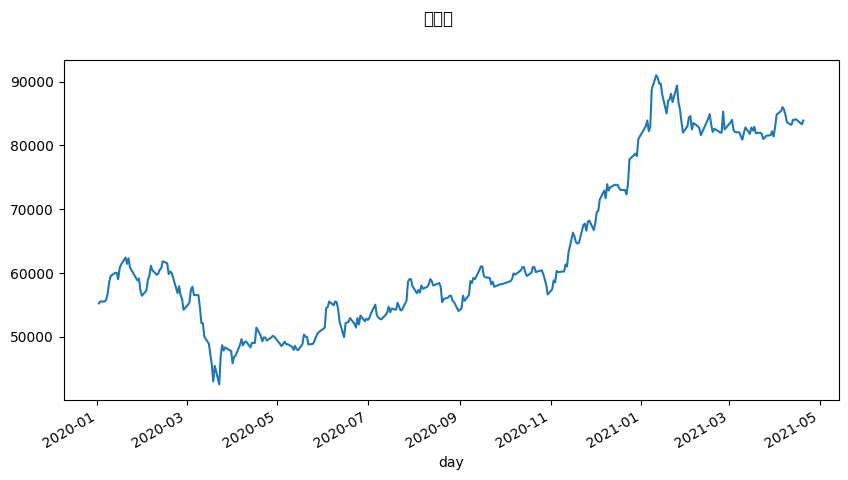

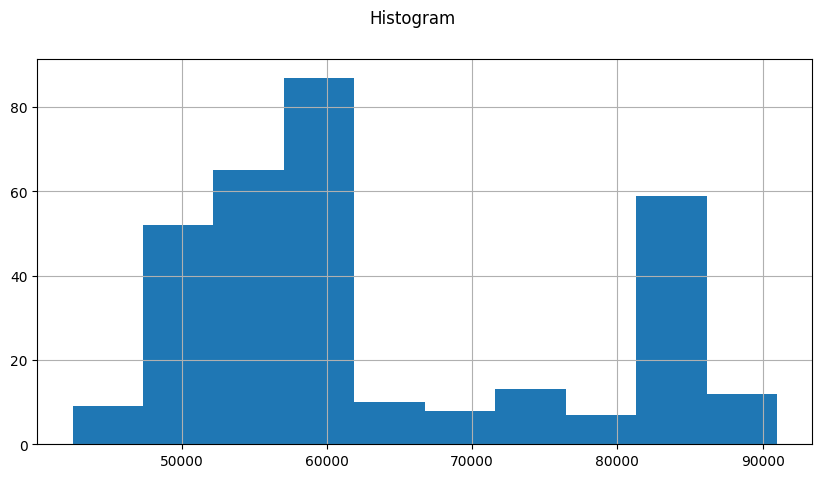

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('그래프')
samsung_df['price'].plot(ax=ax)
plt.show()


fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Histogram')
samsung_df['price'].hist(ax=ax)
plt.show()

- 정상성 만족 X
- 날짜의 흐름대로 그래프를 보았을 때, 계절성과 주기성X (모양의 반복X)

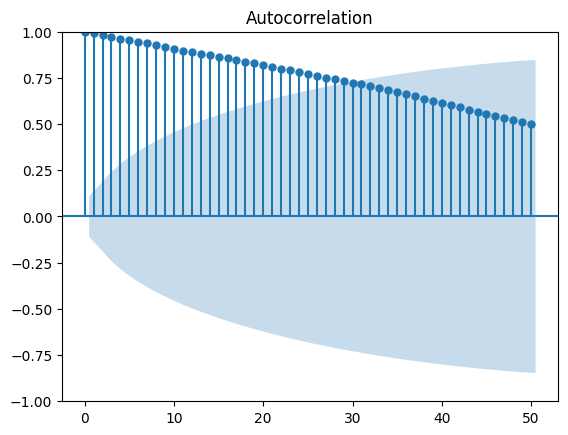

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf
ax1 = plot_acf(samsung_df, lags=50)
plt.show()

- x축은 lag이고 y축은 correlation
- 0일 때는 자기 자신과의 관계기 때문에 1
- 파란색 범위를 벗어나는 부분이 존재하므로 Autocorrelation이 있음.

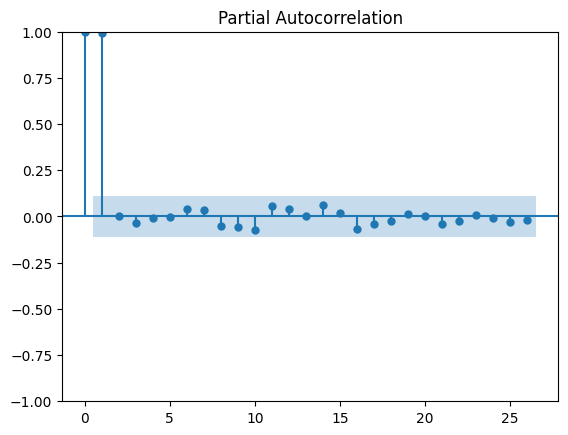

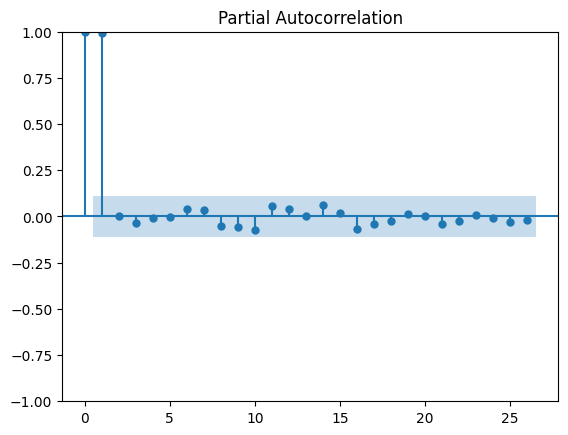

In [23]:
plot_pacf(samsung_df)

PACF그래프를 확인했을 때 시차 차이가 1인 것까지 coreelation이 높음

In [26]:
n_obs = 20
df_train, df_test = samsung_df[0:-n_obs], samsung_df[-n_obs:]

from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

print('ADF Test')
adf_test(samsung_df['price'])

ADF Test
ADF Statistics: -0.212189
p-value: 0.937053
Critical values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


- p-value>0.05니까 귀무가설 기각X
즉, 해당 시계열은 안정적X

In [27]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df):
    statistic, p_value, n_lags, critical_values = kpss(df.values)

    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')

print('KPSS Test')
kpss_test(samsung_df['price'])

KPSS Test
KPSS Statistic: 2.145211628190742
p-value: 0.01
num lags: 11
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


<ipython-input-27-41be7da8f6ec>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(df.values)


- p-value<0.05 니까 귀무가설 기각X 즉, 해당 시계열은 안정적X

In [28]:
model_arima= auto_arima(samsung_df,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(samsung_df)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5477.791, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5479.737, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5481.752, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5483.744, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5479.719, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5481.732, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5483.954, Time=0.80 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5485.673, Time=1.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5481.684, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5483.694, Time=1.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5485.659, Time=0.76 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5487.162, Time=1.96 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5483.681, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5485.686, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5487.236, Time=1.56 sec

Best mode

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

- AIC를 통한 ARIMA를 통해 최적의 ARIMA 모델이 (0,1,0)이라는 것을 파악함
- 이는 1차 차분을 한 모형을 의미하므로 해당 시계열에 대해 1차 차분 진행


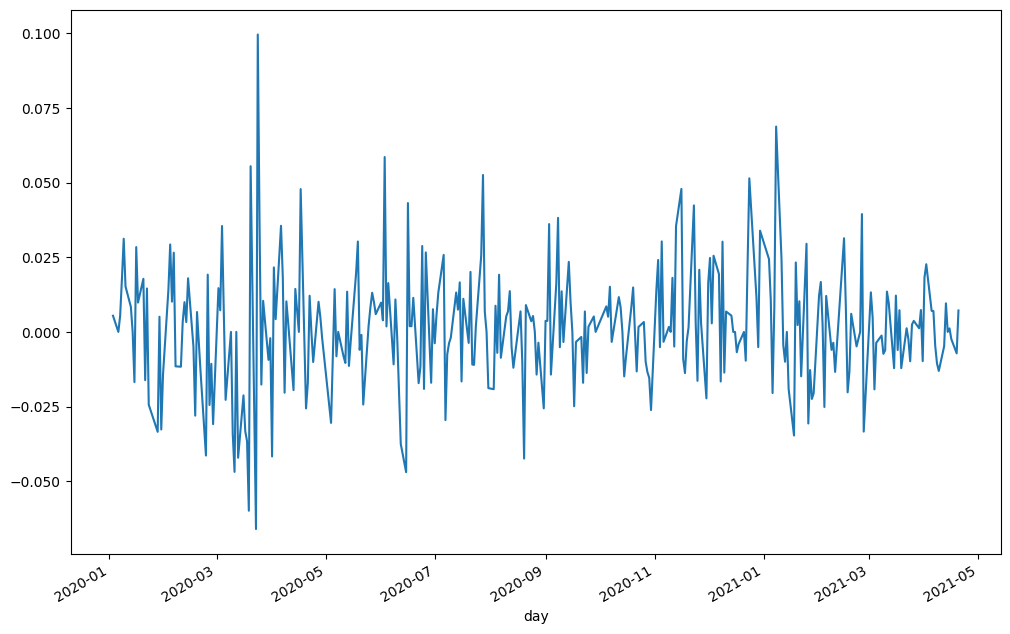

In [29]:
log_df = np.log(samsung_df.price)
log_samsung_df = log_df.diff(1).dropna()

log_samsung_df.plot(figsize=(12, 8))
plt.show()

In [30]:

print("ACF 값 : {0}".format(sm.tsa.stattools.acf(log_samsung_df, nlags=10, fft=False)))
print("PACF 값 : {0}".format(sm.tsa.stattools.pacf(log_samsung_df, nlags=10, method='ywm')))

ACF 값 : [ 1.         -0.02139341  0.08103147 -0.00987534 -0.02735051 -0.05023371
 -0.0132666   0.03894304  0.00678937  0.08097783 -0.12493311]
PACF 값 : [ 1.         -0.02139341  0.08061069 -0.00660291 -0.03444319 -0.05050239
 -0.01041156  0.04676844  0.00906451  0.07182252 -0.12821993]


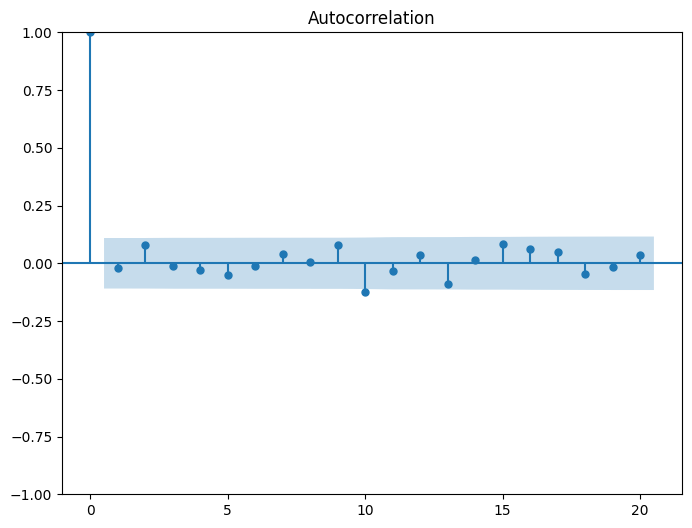

In [31]:
fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(log_samsung_df, lags=20, ax=ax)
plt.show()

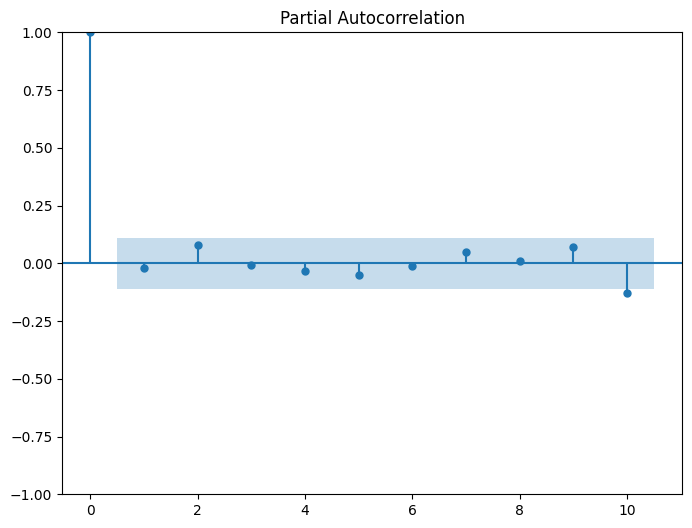

In [32]:
fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
sm.graphics.tsa.plot_pacf(log_samsung_df, lags=10, ax=ax)
plt.show()

- 아까와는 다르게 0인 경우르 제외하고는 모두 파란색 범위 안에 들어감
이를 통해 최종 모델은 ARIMA(0,1,0)으로 결정

### 추정 및 진단

In [33]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  322
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2736.895
Date:                Mon, 28 Aug 2023   AIC                           5477.791
Time:                        07:31:04   BIC                           5485.334
Sample:                             0   HQIC                          5480.803
                                - 322                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     89.4081     70.873      1.262      0.207     -49.501     228.317
sigma2       1.49e+06   8.82e+04     16.903      0.000    1.32e+06    1.66e+06
Ljung-Box (L1) (Q):                   0.05   Jarque-

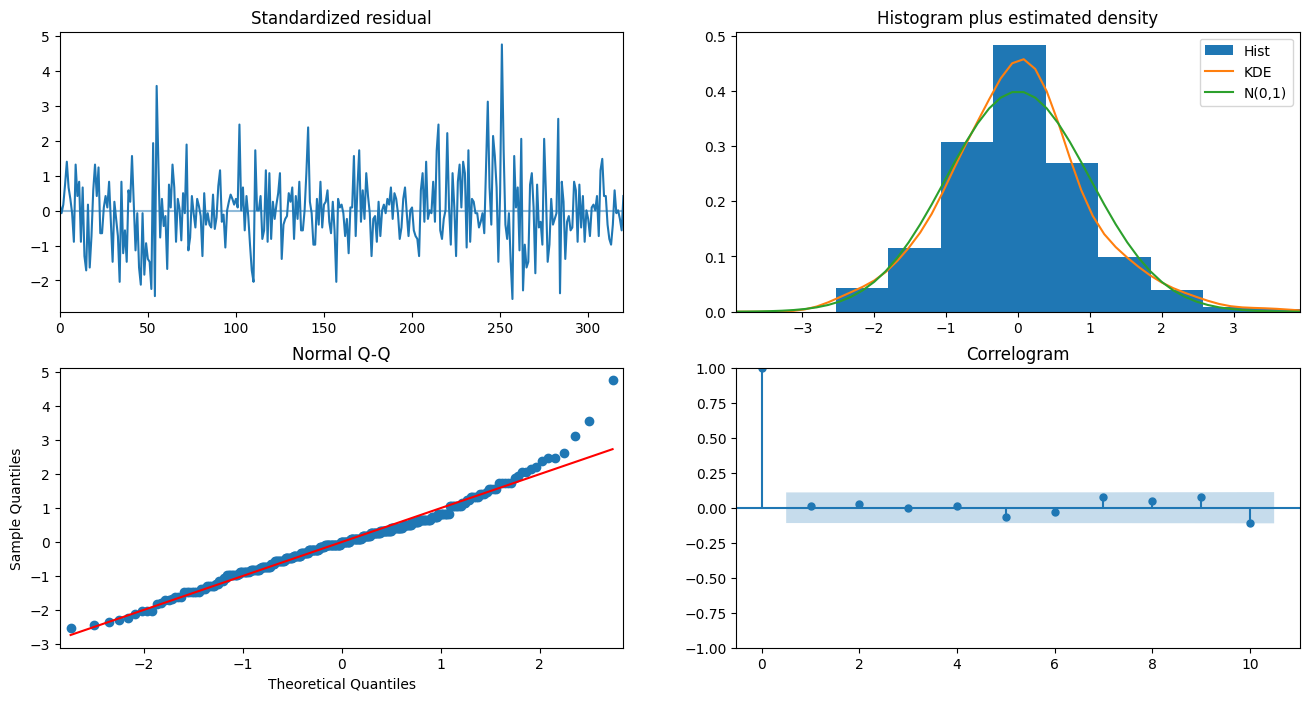

In [34]:
model_arima.plot_diagnostics(figsize=(16, 8))
plt.show()

- p-value와 그래프를 바탕으로 모형이 잘 적합되었다고 판단 가능

### 예측

In [44]:
pd_log = pd.DataFrame(log_df)

model = sm.tsa.arima.ARIMA(pd_log, order = (0,1,0))
model_fit = model.fit()
forecast = model_fit.predict()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


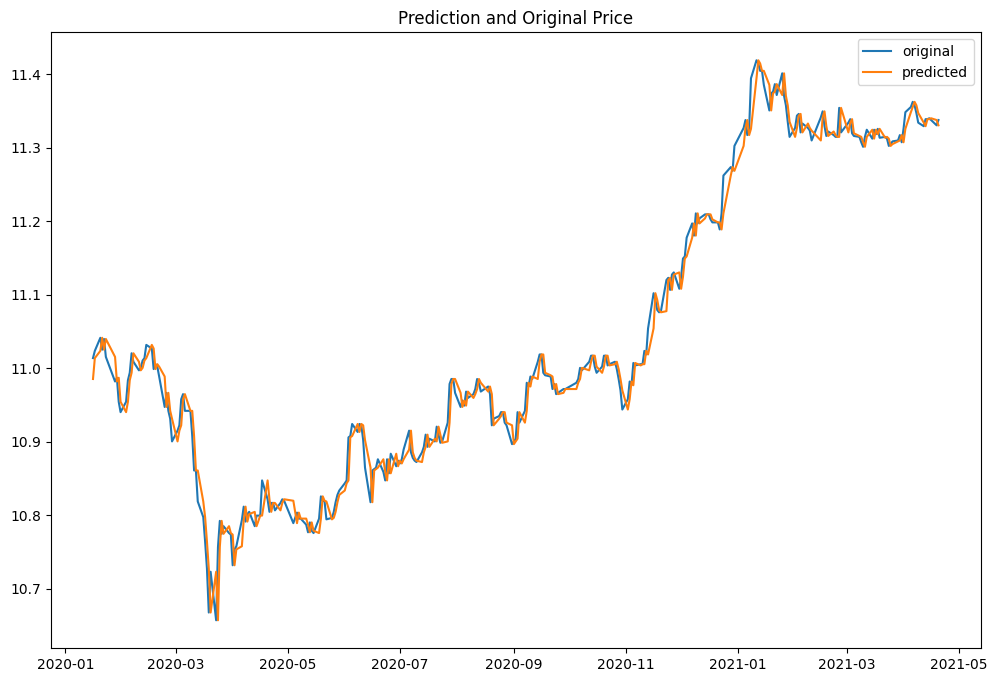

In [46]:
plt.figure(figsize=(12,8))
plt.plot(pd_log[10:], label = 'original')
plt.plot(forecast[10:], label = 'predicted')
plt.legend()
plt.title('Prediction and Original Price')
plt.show()